<a href="https://colab.research.google.com/github/laurenz-coac/mless/blob/main/homework1/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skip connection in  [Resnet](https://arxiv.org/abs/1512.03385)

In ResNet architectures, a skip connection, often referred to as a "skip layer," provides a shortcut path for the input tensor to bypass one or more layers in the network.  Instead of directly feeding the output of a layer to the next, the skip connection adds the input tensor to the output of the layer.  Mathematically, this looks like:

`Output = F(Input) + Input`

where `F` represents the transformations performed by one or more layers within the residual block, and `Input` is the activation from the previous layer.

### Benefits of skip connection:

* **Addressing Vanishing/Exploding Gradients:**  The skip connection facilitates the flow of gradients during backpropagation, helping to mitigate the vanishing or exploding gradient problem. The direct path for the gradients allows them to propagate more easily through the network, especially in deep architectures where these problems are more pronounced.  The gradients have an easier path to update weights in earlier layers, allowing the network to learn effectively.

* **Enabling Deeper Networks:**  By easing gradient flow, skip connections enable the training of significantly deeper networks.  Deeper networks, in theory, have greater capacity to learn complex features. Without skip connections, very deep networks are difficult or impossible to train due to vanishing gradients.

* **Improved Optimization:** Skip connections are not simply a shortcut for the data, but a mechanism to optimize the network. The network learns *residual functions* — the difference between the desired output and the input — rather than learning the complete mapping directly.  This allows the network to learn incremental improvements on top of what's already been learned.


NB: The skip connection is a crucial component of ResNet architectures, allowing for the construction and training of extremely deep networks by improving gradient flow and enabling the learning of residual mappings. This has revolutionized the field of Computer Vision which has become the state of the art model and showed competitive results on [Imagenet](https://www.image-net.org/).


## Schematic figure of Resnet (source:Wikepedia)

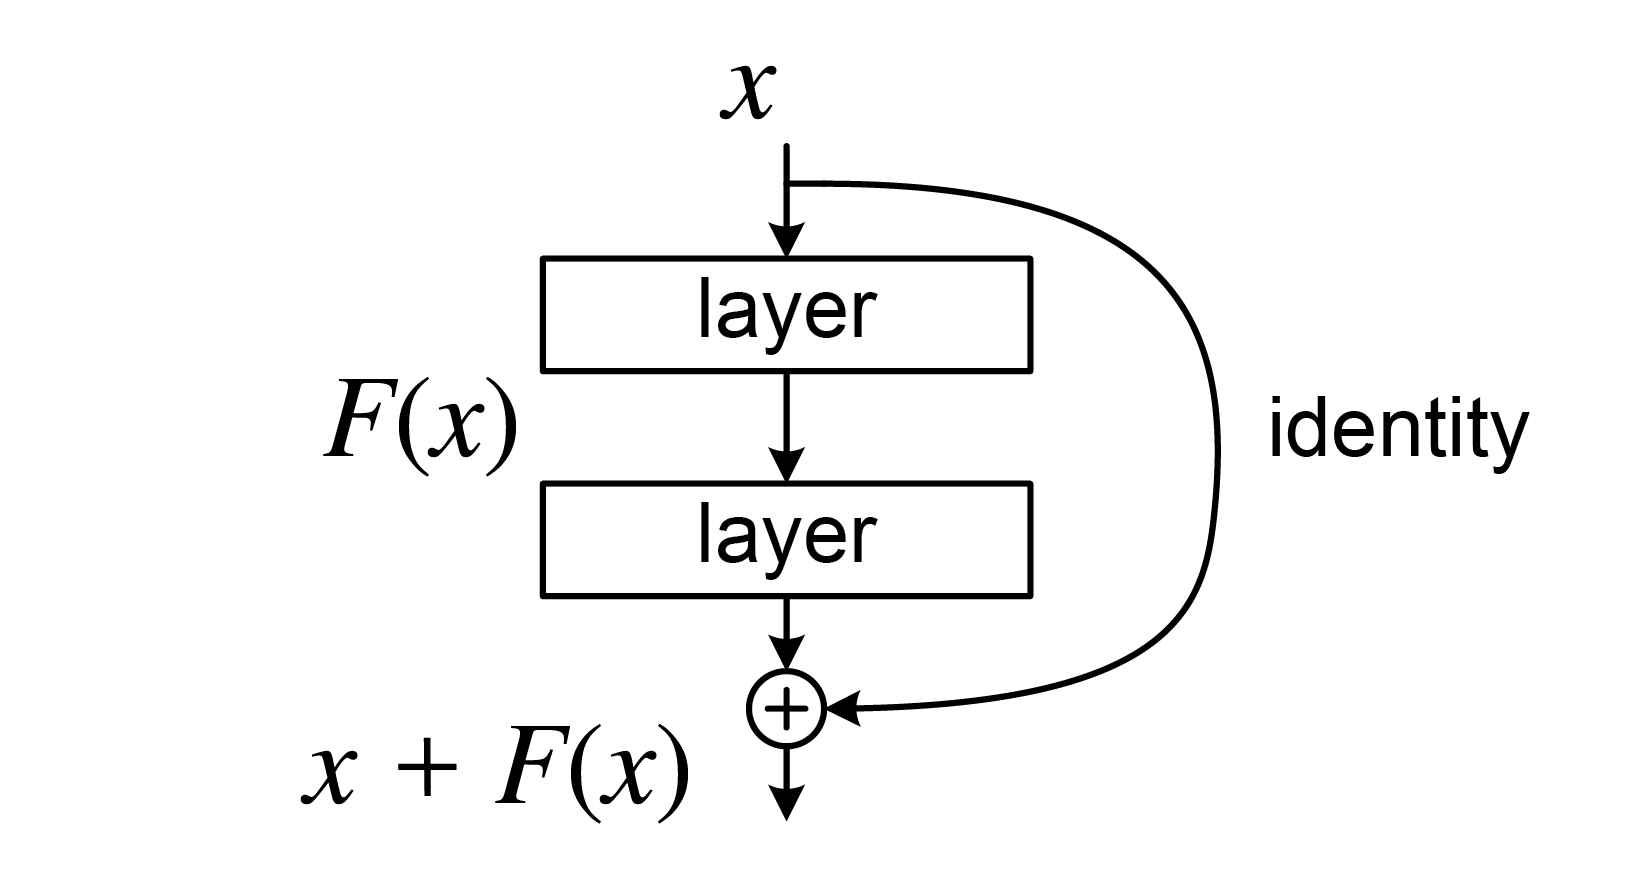

In [ ]:
## Write a torch module for one skip layer as shown in the figure below

## A layer in the figure represent a sequential layer of conv layer -> batchnorm -> Activation function(ReLu)

## We expect by now, you have learnt about different arguments of torch.nn.Conv2D module like in_channels, out_channels, kernel_size, stride, and padding

##import modules whichever required

import torch

class SkipLayer(torch.nn.Module):
  def __init__(self, in_c, kernel_size) -> None:
    super().__init__()

    self.layers = torch.nn.ModuleList(
      [
      torch.nn.Sequential(
        torch.nn.Conv2d(in_c,
                        in_c, # projection to same number of channels
                        kernel_size,
                        stride=1,
                        padding='same',
                        bias=True),
        torch.nn.BatchNorm2d(in_c),
        torch.nn.ReLU()) 
      for _ in range(2)]
    )

  def forward(self,x):
    x_p = x
    for layer in self.layers:
      x_p = layer(x_p)
    x = x + x_p
    return x


In [21]:
## Test your module

# 16-batchsize
# 4-channels
# 28 \times 28 - height \times width

random_sample = torch.randn((16,4,28,28))
skip_layer = SkipLayer(in_c=4, kernel_size=3)
print(skip_layer(random_sample).shape)

torch.Size([16, 4, 28, 28])


## Torchvision's Resnet [github](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
Now, that you have learnt what is skip connection module, now its time to use a Resnet module to our classification tasks on SAT-6 dataset.

Try to replace our predefined CNN with Resnet. Use already available Resnet module

Hints: The Resnet module from torchvision is developed for RGB images where input image has 3 channels. Please try to change it.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

### Data Preparation

In [3]:
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/sat6annotations.csv

--2025-05-29 16:09:00--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 905628829 (864M) [text/plain]
Saving to: ‘X_test_sat6.csv’

X_test_sat6.csv     100%[===================>] 863.67M  20.2MB/s    in 44s     

2025-05-29 16:09:45 (19.6 MB/s) - ‘X_test_sat6.csv’ saved [905628829/905628829]

--2025-05-29 16:09:45--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 972000 (949K) [text/plain]
Saving to: ‘y_test_sat6.csv’

y_test_sat6.csv     100%[===================>] 949.22K  1.13MB/s    in 0.8s    

2025-05-29 16:09

In [4]:
class SAT6Dataset(Dataset):
  def __init__(self,data_df,label_df, normalization_parameter):
    super(SAT6Dataset,self).__init__()
    self.data_df = data_df
    self.label_df = label_df
    self.normalization = normalization_parameter

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self,idx):
    data = self.data_df.iloc[idx].values.reshape((28,28,4)).astype(np.float32)
    data = (data-self.normalization[0])/self.normalization[1]
    #data = data/255.0
    data = np.transpose(data,axes=(2,0,1))
    label = self.label_df.iloc[idx].values
    label_args = np.where(label==1)[0]

    return (data,label_args[0])

In [5]:
landcover_df = pd.read_csv("./X_test_sat6.csv",header=None)
annotations = pd.read_csv("./sat6annotations.csv", header=None)
labels = annotations[0].values

labels_df = pd.read_csv("./y_test_sat6.csv",header=None)
column_names = labels_df.columns.values

# split
num_train = 1000 #replace with -1 if all samples need to be used for training
num_test = 100
train_idx = []
test_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_train and num_test values from this index list - make sure to avoid duplicates
    valid_indices = np.where(class_idx.values)[0]
    random_indices = np.random.permutation(valid_indices)
    test_idx.extend(random_indices[:num_test])
    train_idx.extend(random_indices[num_test:num_test+num_train if num_train != -1 else num_train])
print(f'number of train indices: {len(train_idx)}, number of test indices: {len(test_idx)}')

train_X = landcover_df.iloc[train_idx]
train_y = labels_df.iloc[train_idx]
test_X = landcover_df.iloc[test_idx]
test_y = labels_df.iloc[test_idx]

train_X_reshape = train_X.values.reshape((-1,28,28,4))
mean_per_channels = np.mean(train_X_reshape,axis=(0,1,2)).astype(np.float32)
std_per_channels = np.std(train_X_reshape,axis=(0,1,2)).astype(np.float32)
mean_per_channels, std_per_channels

sat6_train_dataset = SAT6Dataset(train_X,train_y,(mean_per_channels,std_per_channels))
sat6_test_dataset = SAT6Dataset(test_X,test_y,(mean_per_channels,std_per_channels))

train_dataloader = DataLoader(sat6_train_dataset,batch_size=256,shuffle=True,drop_last=True)
test_dataloader = DataLoader(sat6_test_dataset,len(sat6_test_dataset), shuffle=False)

number of train indices: 6000, number of test indices: 600


## Train Setup

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [49]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True) # use pretrained model because we are only changing the first and last layer

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
# take a look at the architecture
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
# we need to modify conv1 to take 4 channels as input
resnet.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# and we modify the last fc projection layer to fit the 6 class problem
resnet.fc = torch.nn.Linear(in_features=512, out_features=6, bias=True)

In [52]:
# verify
resnet

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
optim = "adam"
optimizer = torch.optim.Adam(resnet.parameters(),lr=0.001) if optim == "adam" else torch.optim.SGD(resnet.parameters(),lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

In [54]:
num_epochs = 10
training_loss_per_epoch = []
validation_loss_per_epoch = []
acc_per_epoch = []
resnet.to(device)

with tqdm(total=num_epochs) as pbar:
  for i in range(num_epochs):
    resnet.train()
    for train_data_idx, train_data in enumerate(train_dataloader):
      optimizer.zero_grad()
      data, labels = train_data
      data = data.to(device)
      labels = labels.to(device)
      preds = resnet(data)
      train_loss = loss_fn(preds,labels)
      train_loss.backward()
      optimizer.step()

    training_loss_per_epoch.append(train_loss.item())

    resnet.eval()
    pred_labels = []
    true_labels = []
    with torch.no_grad():
      for test_data_idx, test_data in enumerate(test_dataloader):
        data, labels = test_data
        data = data.to(device)
        labels = labels.to(device)
        preds = resnet(data)
        val_loss = loss_fn(preds,labels)
        pred_labels.extend(torch.argmax(preds,dim=1).to('cpu'))
        true_labels.extend(torch.squeeze(labels).to('cpu'))
    validation_loss_per_epoch.append(val_loss.item())
    acc = accuracy_score(true_labels,pred_labels)
    acc_per_epoch.append(acc)
    pbar.set_description(f"Epoch {i+1}/{num_epochs}: training_loss : {train_loss}, validation_loss : {val_loss} and accuracy : {acc} ")

Epoch 10/10: training_loss : 0.006558531429618597, validation_loss : 0.13963276147842407 and accuracy : 0.96 :   0%|          | 0/10 [00:13<?, ?it/s]


## Evaluation Metrics

In [55]:
resnet.eval()
pred_labels = []
pred_probas = []
true_labels = []
with torch.no_grad():
  for test_data_idx, test_data in enumerate(test_dataloader):
    data, labels = test_data
    data = data.to(device)
    labels = labels.to(device)
    preds = resnet(data)
    val_loss = loss_fn(preds,labels)
    pred_labels.extend(torch.argmax(preds,dim=1).to('cpu'))
    pred_probas.extend(torch.softmax(preds,dim=1).to('cpu'))
    true_labels.extend(torch.squeeze(labels).to('cpu'))

### Kappa Score


In [56]:
pred_labels, true_labels = np.array(pred_labels), np.array(true_labels)

In [57]:
c = np.sum(pred_labels == true_labels) # correctly predicted
s = len(pred_labels) # total number of elements
p = [sum(pred_labels == k) for k in np.unique(true_labels)] # array of number predicted per class
t = [sum(true_labels == k) for k in np.unique(true_labels)] # array of number true per class


In [59]:
p_times_t = np.inner(p, t)

In [60]:
K = (c*s - p_times_t)/(s**2 - p_times_t)
K

np.float64(0.952)

The Kappa Score is 0.952.

### ROC Curve

In [61]:
pred_probas = np.array(pred_probas)

In [62]:
pred_probas.shape

(600, 6)

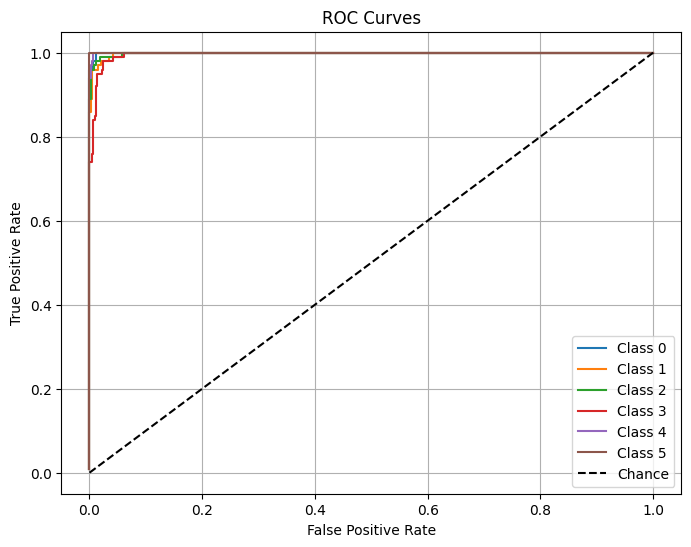

In [66]:
plt.figure(figsize=(8, 6))
for pos_label in np.unique(true_labels):

    # plot ROC curve for a single label
    y_true_bin = (true_labels == pos_label).astype(int)
    y_score = pred_probas[:, pos_label]

    # sort scores and corresponding labels
    desc_score_indices = np.argsort(-y_score)
    y_score = y_score[desc_score_indices]
    y_true_bin = y_true_bin[desc_score_indices]

    # collect true and false positive counts for different thresholds
    tps = np.cumsum(y_true_bin)
    fps = np.cumsum(1 - y_true_bin)

    # calculate true/false positive rates
    tpr = tps / tps[-1] if tps[-1] > 0 else np.zeros_like(tps)
    fpr = fps / fps[-1] if fps[-1] > 0 else np.zeros_like(fps)
    plt.plot(fpr, tpr, label=f'Class {pos_label}')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()